[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/FairSense/blob/main/docs/notebooks/quickstart.ipynb)

## Quick start: how to read indices ?

In [1]:
# !pip install fairsense

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deel.fairsense.indices import cvm_indices, sobol_indices, with_confidence_intervals
from deel.fairsense.utils.dataclasses import IndicesInput
from deel.fairsense.utils.fairness_objective import y_pred
from deel.fairsense.visualization import cat_plot, format_with_intervals

# The data

In this example we will highlight sobol indices properties using a very simple distribution: a 3 variable gaussian distribution where the variances and covariances can be controlled.

In [3]:
def gaussian_data_generator(sigma12, sigma13, sigma23, N, var1=1.0, var2=1.0, var3=1.0):
    cov = np.mat(
        [[var1, sigma12, sigma13], [sigma12, var2, sigma23], [sigma13, sigma23, var3]]
    )
    x = np.random.multivariate_normal(mean=np.array([0, 0, 0]), cov=cov, size=N)
    return pd.DataFrame(x, columns=[0, 1, 2])

# Intro: Computing the indices

In order to compute the indices, we must start with building an `IndiceInput` object, which can be done by providing a dataset, a model and an objective.

In [4]:
model = lambda x: x["0"] # "f(X_0, X_1, X_2) -> X_0"
data = gaussian_data_generator(sigma12=0., sigma13=0., sigma23=0., N=10**3)
objective = y_pred
inputs = IndicesInput(model=model, x=data, objective=objective)

We can now compute indices using the functions provided in `deel.fairsense.indices`. Results can be stacked using the `+` operator.

In [5]:
results = sobol_indices(inputs, n=10**3) + cvm_indices(inputs)
results.values.head()

,S,ST,S_ind,ST_ind,CVM,CVM_indep
0,1.000000,1.000000,1.0,1.000000,0.998266,0.885574
1,0.006139,0.003298,0.0,0.000364,0.035952,0.000000
2,0.001230,0.001075,0.0,0.001849,0.035325,0.000000


We can also enrich usual indices to compute confidence intervals (computed using k-fold over the data)

In [6]:
sobol_with_ci = with_confidence_intervals(n_splits=31)(sobol_indices)
results = sobol_with_ci(inputs, n=10**3)
format_with_intervals(results)

100%|███████████████████████████████████████████| 31/31 [00:02<00:00, 13.41it/s]


,S,ST,S_ind,ST_ind
0,"0.99 [0.95, 1.00]","0.99 [0.96, 1.00]","0.92 [0.75, 1.00]","0.95 [0.82, 1.00]"
1,"0.02 [0.00, 0.16]","0.04 [0.00, 0.20]","0.00 [0.00, 0.00]","0.00 [0.00, 0.01]"
2,"0.01 [0.00, 0.07]","0.02 [0.00, 0.11]","0.00 [0.00, 0.01]","0.01 [0.00, 0.01]"


# How to read the indices

GSA indices quantify how much of a variable influences the variance of the output of a function. It is import to recall that a variable can be influent in numerous ways:

- a variable can be influent by itself
- a variable can be influent becaus it is correlated to an influent variable
- a variable can be influent because of a joint effect with another variable (ex: `cold + no salt on road + rain => slippery road` is an example where each variable is not influent by itself but is influent when joined with other )

There is 4 Sobol indices that allow to give clues about how a variable is influent.

## Sobol indices and input distribution

for the function `f(X_0, X_1, X_2) -> X_0 + X_1`, the sobol indices that `X_0` and `X_1` a both equally influent :

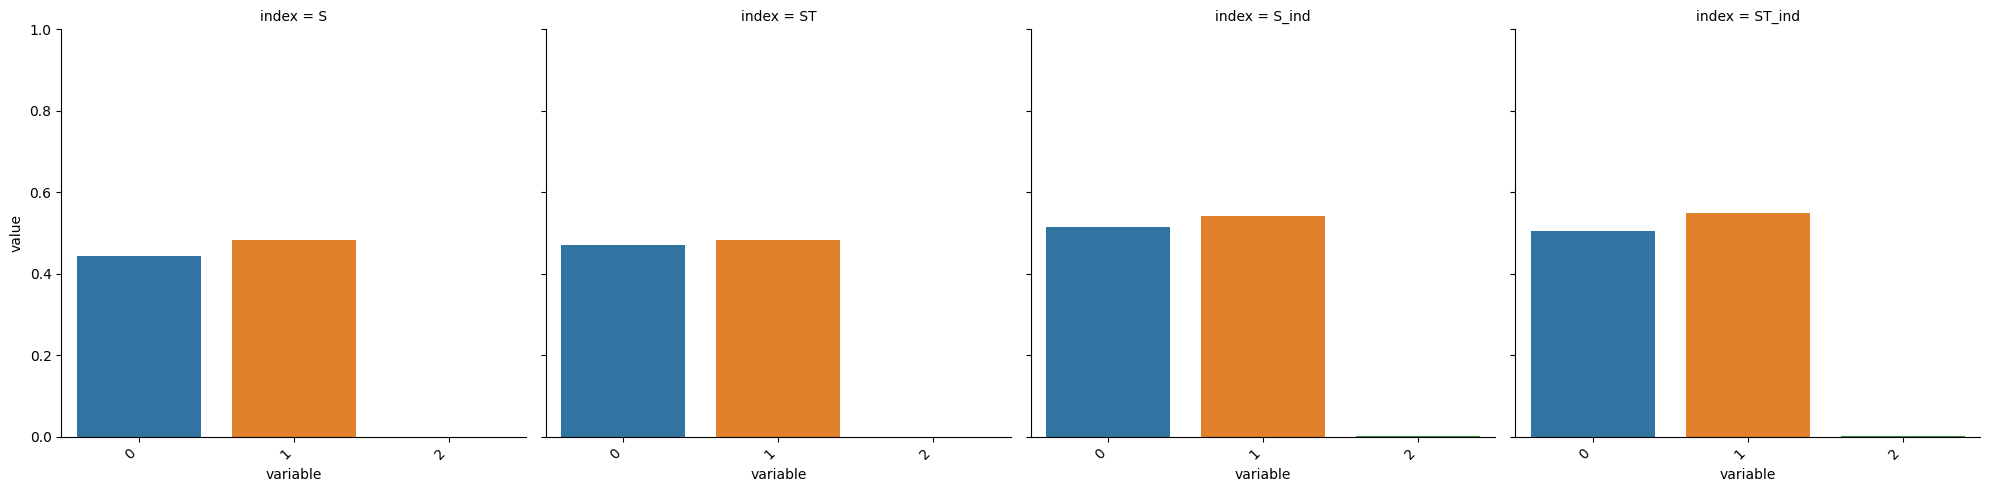

In [7]:
model = lambda x: x["0"] + x["1"] + 0.001 * x["2"] # "f(X_0, X_1, X_2) -> X_0 + X_1"
data = gaussian_data_generator(sigma12=0., sigma13=0., sigma23=0., N=10**3)
objective = y_pred
inputs = IndicesInput(model=model, x=data, objective=objective)
results = sobol_indices(inputs, n=10**3)# + cvm_indices(inputs)
cat_plot(results, plot_per="index", kind="bar")
plt.show()

However, it is important to recall that Sobol indices accounts for the input distribution. For instance when $ var(X_0) = 10 $ and $ var(X_1) = 1 $ the indices reveals that in practice $ X_0 $ is more influent than $ X_1 $:

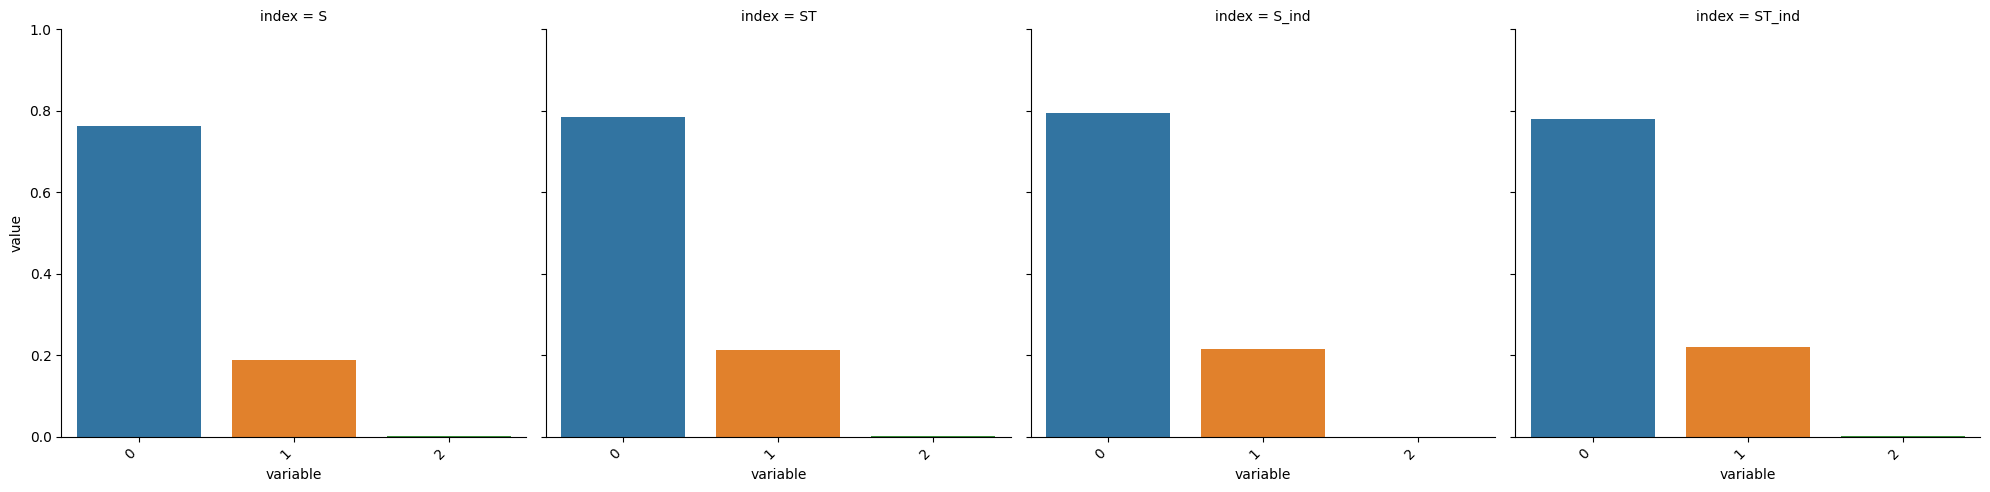

In [8]:
model = lambda x: x["0"] + x["1"] # "f(X_0, X_1, X_2) -> X_0 + X_1"
data = gaussian_data_generator(sigma12=0., sigma13=0., sigma23=0., var1=10, N=10**3)
objective = y_pred
inputs = IndicesInput(model=model, x=data, objective=objective)
results = sobol_indices(inputs, n=10**3)# + cvm_indices(inputs)
cat_plot(results, plot_per="index", kind="bar")
plt.show()

## Sobol indices and correlations

When a variable is influent trough correlations, sobol indices account it's influence, while Sobol independent does not.
This can be observed in this example where:
$$ f(X_0, X_1, X_2) = X_0 $$
And $X_1$ and $X_2$ are both correlated to $X_0$ with a 0.5 correlation coefficient.

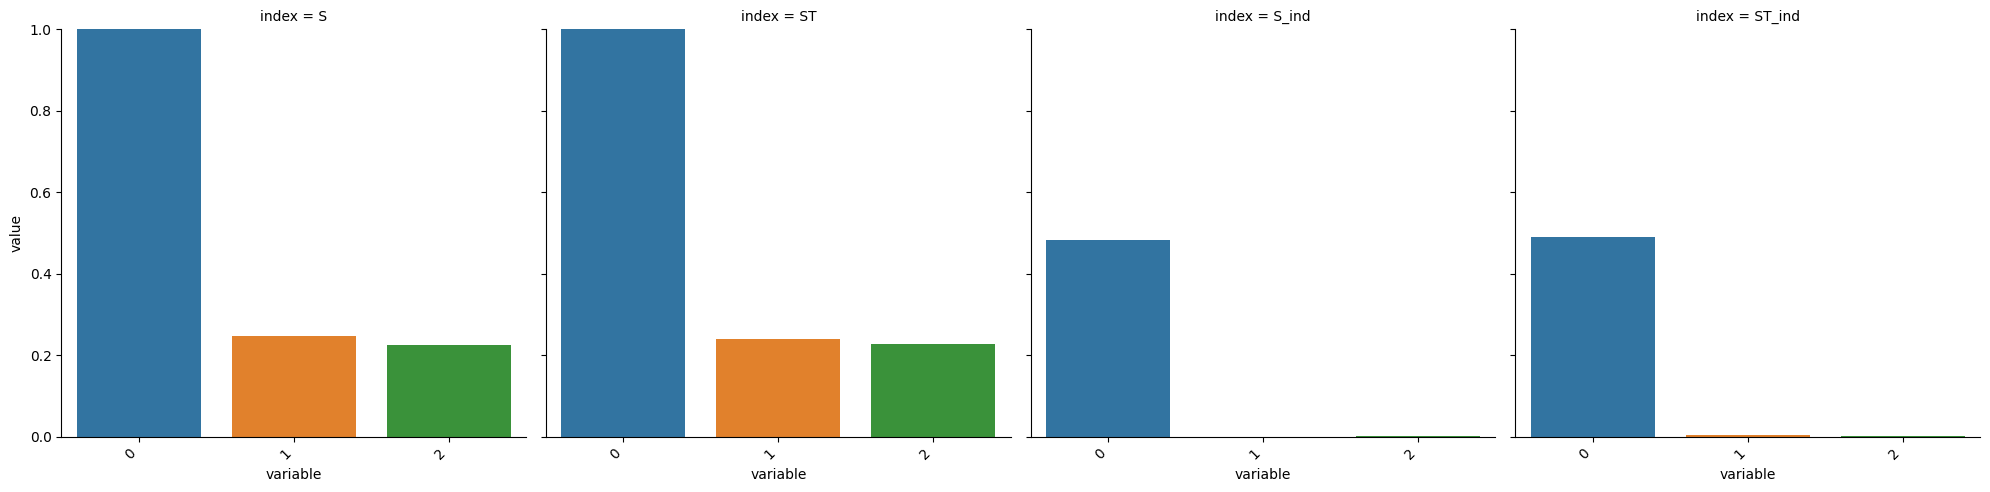

In [9]:
model = lambda x: x["0"] # "f(X_0, X_1, X_2) -> X_0"
data = gaussian_data_generator(sigma12=0.5, sigma13=0.5, sigma23=0., N=10**3)
objective = y_pred
inputs = IndicesInput(model=model, x=data, objective=objective)
results = sobol_indices(inputs, n=10**3)# + cvm_indices(inputs)
cat_plot(results, plot_per="index", kind="bar")
plt.show()

## Sobol indices and joint effects

When a variable is influent trough joint effects, sobol total indices account it's influence, while Sobol does not.
This can be observed in this example where:
$$ f(X_0, X_1, X_2) = 20*X_0 \text{ if } X_1 \text{ and } X_2 \leq 0.5 \\ = 1.0*X_0 \text{ otherwise } $$

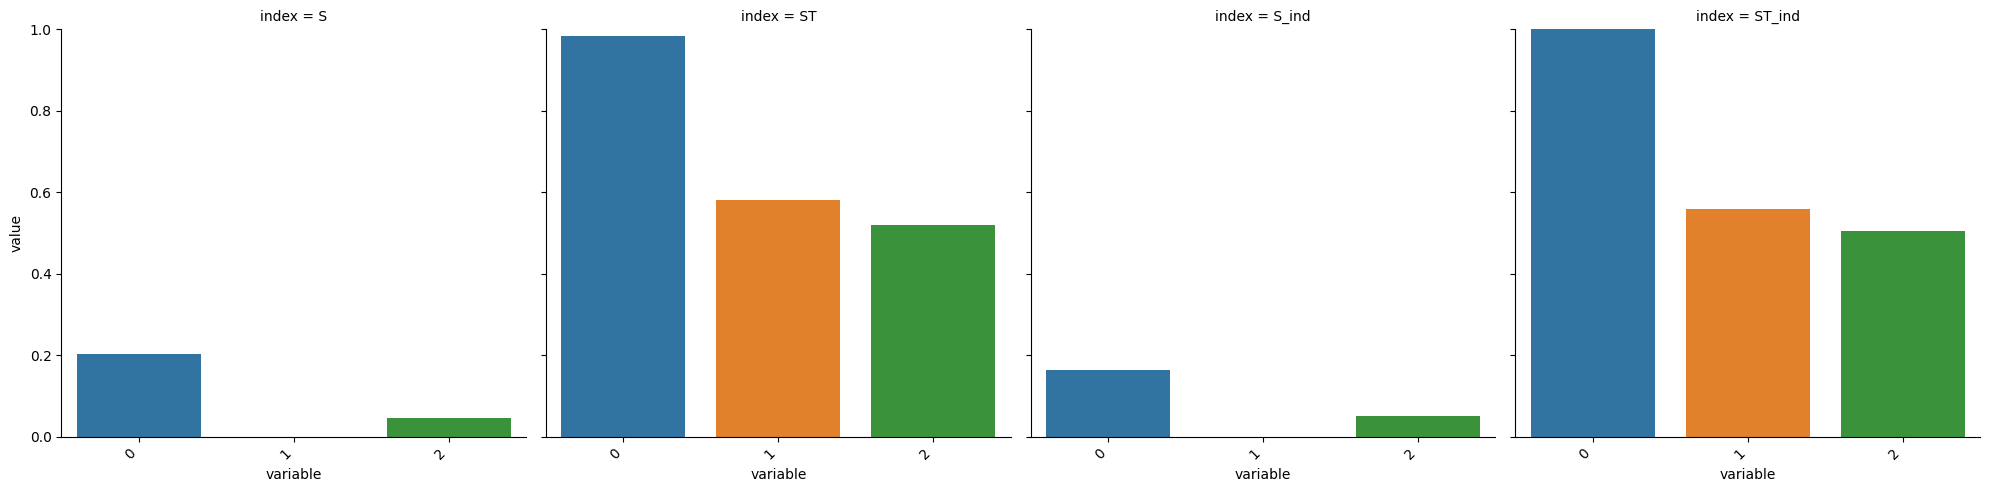

In [10]:
model = lambda x: x["0"] * (((x["1"] > 0) * (x["2"] > 0) * 20) + -10) #  "f(x) -> 20*X_0 if (X_1 > 0.5) && (X_2 > 0.5) else: 0.25*X_0 "
data = gaussian_data_generator(sigma12=0., sigma13=0., sigma23=0., N=10**3)
objective = y_pred
inputs = IndicesInput(model=model, x=data, objective=objective)
results = sobol_indices(inputs, n=10**3)# + cvm_indices(inputs)
cat_plot(results, plot_per="index", kind="bar")
plt.show()